In [1]:
import numpy as np
import os
import pandas as pd
import scipy.stats as stats
import scipy
import matplotlib.pyplot as plt
import sklearn
import sklearn.neural_network

In [2]:
# Directory containing the files (current working directory)
current_dir = os.getcwd()  # gets the path of the folder where the code is run
Hovsore_data_filepath = os.path.join(current_dir, 'HovsoreData_Sonic_100m_2004-2013.csv')
DEL_data_filepath = os.path.join(current_dir, 'ML_ExampleDataSet.xlsx')
# Load Hovsore wind data CSV
Hovsore_data = pd.read_csv(Hovsore_data_filepath)

# Load DEL data from Excel
DEL_data = pd.read_excel(DEL_data_filepath)  # Read all sheets for now

# Preview the datasets
Hovsore_data.head()
#DEL_data.head()


,Timestamp,Wsp,TI,"TI,detrend",MeanDir,MeanTrigDir,StdDir,MinDir,MaxDir
0,200410010000,9.9196,0.0181,0.0145,346.7130,346.7130,0.8440,343.893,349.044
1,200410010020,9.5073,0.0145,0.0116,346.9852,346.9852,0.6518,344.751,348.949
2,200410010030,9.5274,0.0210,0.0195,346.9152,346.9151,0.7949,343.754,350.588
3,200410010040,9.9498,0.0253,0.0195,346.3204,346.3204,0.7549,343.971,349.953
4,200410010050,10.2376,0.0151,0.0134,345.4185,345.4185,0.6362,343.074,348.960


In [3]:
# Remove rows where Wsp is greater than 50
Hovsore_filtered_data = Hovsore_data[Hovsore_data['Wsp'] <= 50].reset_index(drop=True)

# Add a new column 'Total_Cost' that is the product of 'Quantity' and 'Price_per_Item'
Hovsore_filtered_data['SigmaU'] = Hovsore_filtered_data['Wsp'] * Hovsore_filtered_data['TI']

In [4]:
Hovsore_filtered_data

,Timestamp,Wsp,TI,"TI,detrend",MeanDir,MeanTrigDir,StdDir,MinDir,MaxDir,SigmaU
0,200410010000,9.9196,0.0181,0.0145,346.7130,346.7130,0.8440,343.893,349.044,0.179545
1,200410010020,9.5073,0.0145,0.0116,346.9852,346.9852,0.6518,344.751,348.949,0.137856
2,200410010030,9.5274,0.0210,0.0195,346.9152,346.9151,0.7949,343.754,350.588,0.200075
3,200410010040,9.9498,0.0253,0.0195,346.3204,346.3204,0.7549,343.971,349.953,0.251730
4,200410010050,10.2376,0.0151,0.0134,345.4185,345.4185,0.6362,343.074,348.960,0.154588
...,...,...,...,...,...,...,...,...,...,...
438539,201308312310,15.6264,0.0773,0.0589,299.8040,299.8043,2.6738,288.901,309.955,1.207921
438540,201308312320,13.7150,0.0576,0.0576,298.0319,298.0315,3.2644,288.643,309.245,0.789984
438541,201308312330,13.4969,0.0797,0.0654,297.7226,297.7242,3.5721,284.827,306.117,1.075703
438542,201308312340,13.4135,0.1034,0.0901,294.6266,294.6243,3.9459,283.195,310.353,1.386956


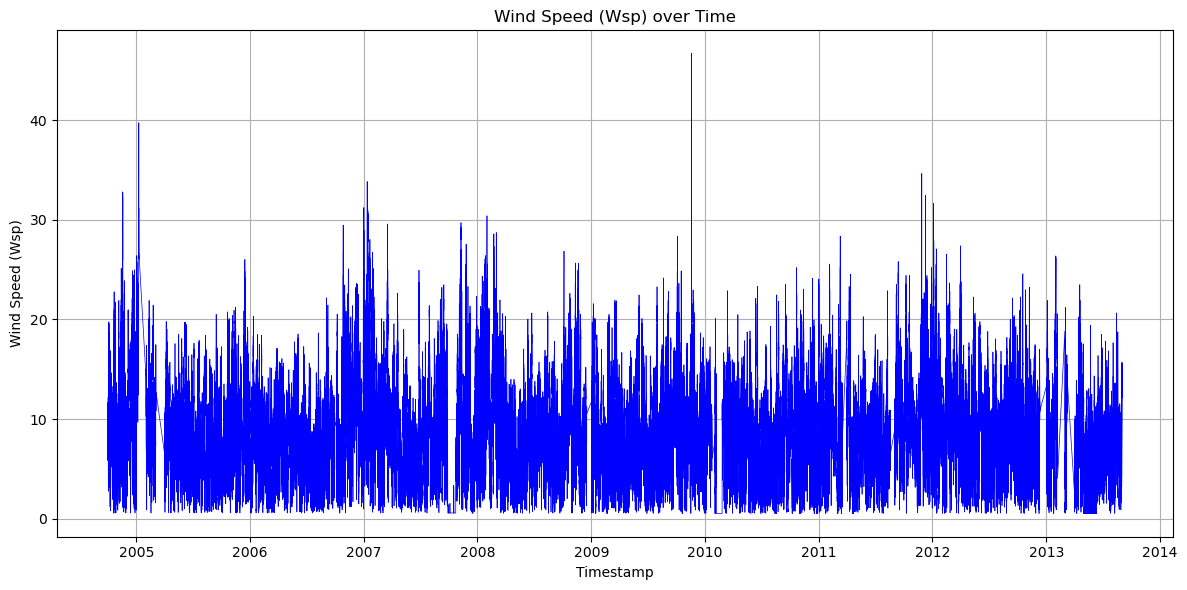

In [5]:
# Convert the Timestamp column to datetime format
Hovsore_filtered_data['Timestamp'] = pd.to_datetime(Hovsore_filtered_data['Timestamp'], format='%Y%m%d%H%M')

# Plotting Wsp against Timestamp
plt.figure(figsize=(12, 6))
plt.plot(Hovsore_filtered_data['Timestamp'], Hovsore_filtered_data['Wsp'], color='blue', linewidth=0.5)
plt.title('Wind Speed (Wsp) over Time')
plt.xlabel('Timestamp')
plt.ylabel('Wind Speed (Wsp)')
plt.grid(True)
plt.tight_layout()

# Display the plot
plt.show()

In [6]:
# WIND SPEED DISTRIBUTION FIT
Wsp0 = np.asarray(Hovsore_filtered_data['Wsp'])
WeibLikelihoodFunc = lambda theta: -np.sum( np.log( stats.weibull_min.pdf(Wsp0, theta[0], loc=0, scale=theta[1]) ) ) # Definition of the negative log-likelihood function
Weib0 = scipy.optimize.minimize(WeibLikelihoodFunc, [1.0, np.std(np.log(Wsp0))])
WeibullA = Weib0.x[0]
Weibullk = Weib0.x[1]

print("A", WeibullA)
print("k", Weibullk)

A 1.9183533011611893
k 9.79703103070675


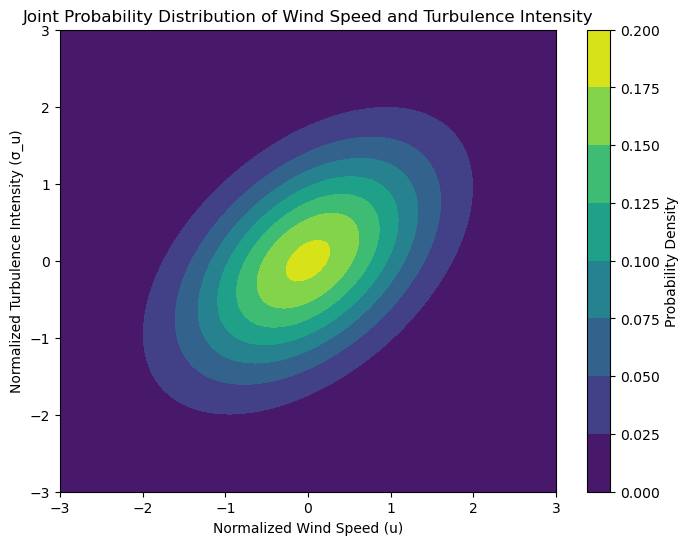

In [7]:
# Extract the wind speed (u) and calculate turbulence (σ_u)
u = Hovsore_filtered_data['Wsp']
sigma_u =  Hovsore_filtered_data['SigmaU']

# Normalize data (z-score transformation)
u_normalized = (u - u.mean()) / u.std()
sigma_u_normalized = (sigma_u - sigma_u.mean()) / sigma_u.std()

# Calculate mean and covariance matrix
mean = [u_normalized.mean(), sigma_u_normalized.mean()]
covariance_matrix = np.cov([u_normalized, sigma_u_normalized])

# Create a grid of points and evaluate the joint distribution
x, y = np.meshgrid(np.linspace(-3, 3, 100), np.linspace(-3, 3, 100))
pos = np.dstack((x, y))
rv = stats.multivariate_normal(mean, covariance_matrix)

# Plot the joint probability distribution
plt.figure(figsize=(8, 6))
plt.contourf(x, y, rv.pdf(pos), cmap='viridis')
plt.colorbar(label='Probability Density')
plt.xlabel('Normalized Wind Speed (u)')
plt.ylabel('Normalized Turbulence Intensity (σ_u)')
plt.title('Joint Probability Distribution of Wind Speed and Turbulence Intensity')
plt.show()

In [8]:
# Helper function - Normal distribution
def NormalDist(task,x,mu=0,sigma=1):
    import numpy as np
    if task == 0: # PDF
        y = (1.0/(sigma*np.sqrt(2.0*np.pi)))*np.exp(-((x - mu)**2)/(2.0*(sigma**2)))
    elif task == 1: # Cumulative
        from scipy.special import erf
        y = 0.5*(1.0 + erf((x - mu)/(sigma*np.sqrt(2))))
    elif task == 2: # Inverse
        from scipy.special import erfinv
        y = mu + sigma*np.sqrt(2)*erfinv(2*x - 1)        
    return y

# Helper function - lognormal distribution
def LogNormDist(task,x,mu,sigma):
    import numpy as np
    tol = 1e-16
    mu = np.asarray(mu)
    mu[mu<tol] = tol
    Eps   = np.sqrt(np.log( 1.0+(sigma/mu)**2 ) )
    Ksi   = np.log(mu)-0.5*Eps**2
    if task == 0: # PDF
        x[x<=0] = 1e-8
        u =(np.log(x)-Ksi)/Eps
        y = np.exp(-u*u/2.0)/(Eps*x*np.sqrt(2.0*np.pi))
    elif task == 1: # Cummulative
        x[x<=0] = 1e-8
        u =(np.log(x)-Ksi)/Eps
        y= NormalDist(1, u)
    elif task == 2: # Inverse
        y= np.exp(Ksi+Eps*NormalDist(2, x))
    
    return y

In [9]:
# CONDITION DISTRIBUTION OF TURBULENCE - BASED ON DATA BINNING
WspBinEdges = np.arange(3.5,33.5,1)
WspBinCenters = WspBinEdges[:-1] + 0.5

MuSigmaBinned = np.zeros(len(WspBinCenters))
SigmaSigmaBinned = np.zeros(len(WspBinCenters))

nData = len( Hovsore_filtered_data['Wsp'])
    
# Per wind speed
for iWsp in range(len(WspBinCenters)):
    WspBinSelection = ( Hovsore_filtered_data['Wsp'] > WspBinEdges[iWsp]) & ( Hovsore_filtered_data['Wsp'] <= WspBinEdges[iWsp + 1])
    MuSigmaBinned[iWsp] = np.mean(Hovsore_filtered_data.loc[WspBinSelection,'SigmaU'])
    SigmaSigmaBinned[iWsp] = np.std(Hovsore_filtered_data.loc[WspBinSelection,'SigmaU'])
    
Mudatax = WspBinCenters[~np.isnan(MuSigmaBinned)]
Mudatay = MuSigmaBinned[~np.isnan(MuSigmaBinned)]

# Use polyfit (for example np.polyfit). Which order works well - 0, 1, or 2?
# You can choose the order of the polynomial (0 for constant, 1 for linear, 2 for quadratic)
pMu = np.polyfit(Mudatax, Mudatay, deg=2)


SigmaSigmaRef = np.mean(SigmaSigmaBinned)
        
MuSigmaFunc = lambda u: np.polyval(pMu, u)
SigmaSigmaFunc = lambda u:  SigmaSigmaRef #np.ones(shape = np.shape(u)) * SigmaSigmaRef


In [10]:
Urand = stats.weibull_min.rvs(c= WeibullA, scale = Weibullk, size = 10000)
MuSigmaUrand = MuSigmaFunc(Urand)
Sigma_Urand = SigmaSigmaFunc(Urand)
SigmaUrand = LogNormDist(2, np.random.rand(10000), MuSigmaUrand, Sigma_Urand)

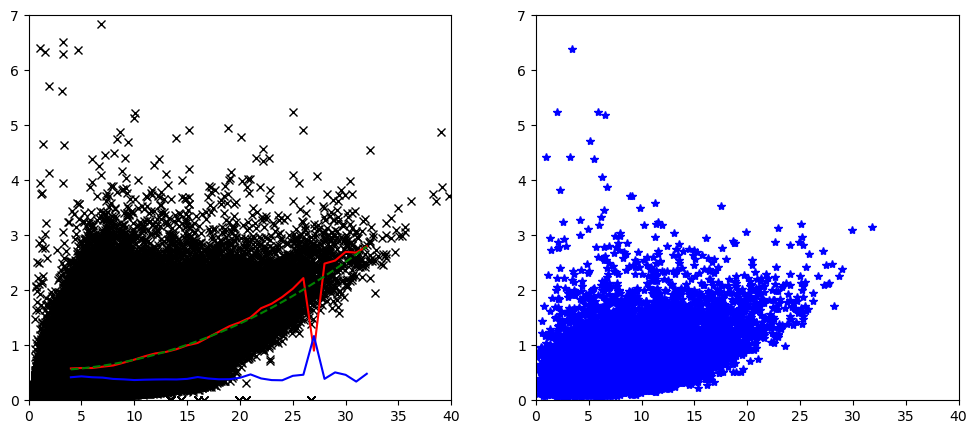

In [11]:
# PLOT TURBULENCE INCLUDING DISTRIBUTION PARAMETERS

fig,ax = plt.subplots(1,2, figsize = (12,5))
ax[0].plot(Hovsore_filtered_data['Wsp'],Hovsore_filtered_data['SigmaU'],'xk')
ax[0].plot(WspBinCenters,MuSigmaBinned,'-r')
ax[0].plot(WspBinCenters,SigmaSigmaBinned,'-b')
ax[0].plot(WspBinCenters,MuSigmaFunc(WspBinCenters),'--g')
ax[0].set_xlim([0,40])
ax[0].set_ylim([0,7])
ax[1].plot(Urand,SigmaUrand,'*b')
ax[1].set_xlim([0,40])
ax[1].set_ylim([0,7])
plt.show()

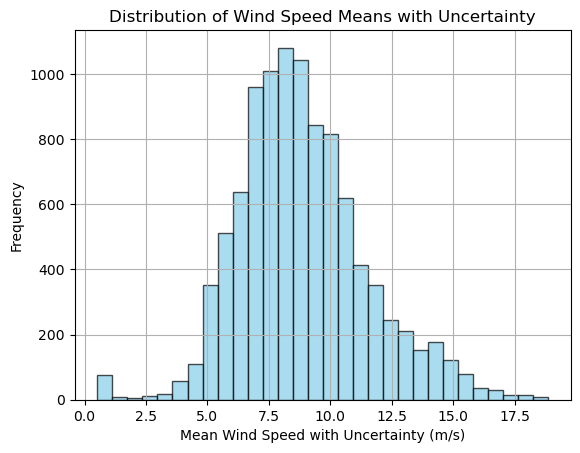

{'Mean': 8.8421502057006,
 'Standard Deviation': 2.6237262100448633,
 'Minimum': 0.5165139999999999,
 'Maximum': 18.871604974000004}

In [12]:
# Set parameters for bootstrapping
bootstrap_iterations = 10000  # Number of bootstrap samples
sample_length = 1000         # Number of consecutive points in each sample (adjustable for continuous segments)

# List to store the means of each bootstrap sample
bootstrap_means = []

# Perform bootstrapping
for _ in range(bootstrap_iterations):
    # Choose a random starting index
    start_index = np.random.randint(0, len(Hovsore_filtered_data) - sample_length)
    # Take a continuous segment of the specified length
    sample = Hovsore_filtered_data['Wsp'][start_index:start_index + sample_length]
    # Calculate and store the mean of the sample
    bootstrap_means.append(sample.mean())

# Convert to numpy array for calculations
bootstrap_means = np.array(bootstrap_means)

# Apply 1% uncertainty for wind speed measurement
adjusted_bootstrap_means = bootstrap_means * 1.01  # Adding 1% uncertainty

# Plotting the distribution of bootstrap means
plt.hist(adjusted_bootstrap_means, bins=30, alpha=0.7, color='skyblue', edgecolor='black')
plt.xlabel('Mean Wind Speed with Uncertainty (m/s)')
plt.ylabel('Frequency')
plt.title('Distribution of Wind Speed Means with Uncertainty')
plt.grid(True)
plt.show()

# Calculate basic statistics of the adjusted bootstrap means
bootstrap_mean_stats = {
    'Mean': np.mean(adjusted_bootstrap_means),
    'Standard Deviation': np.std(adjusted_bootstrap_means),
    'Minimum': np.min(adjusted_bootstrap_means),
    'Maximum': np.max(adjusted_bootstrap_means)
}

bootstrap_mean_stats


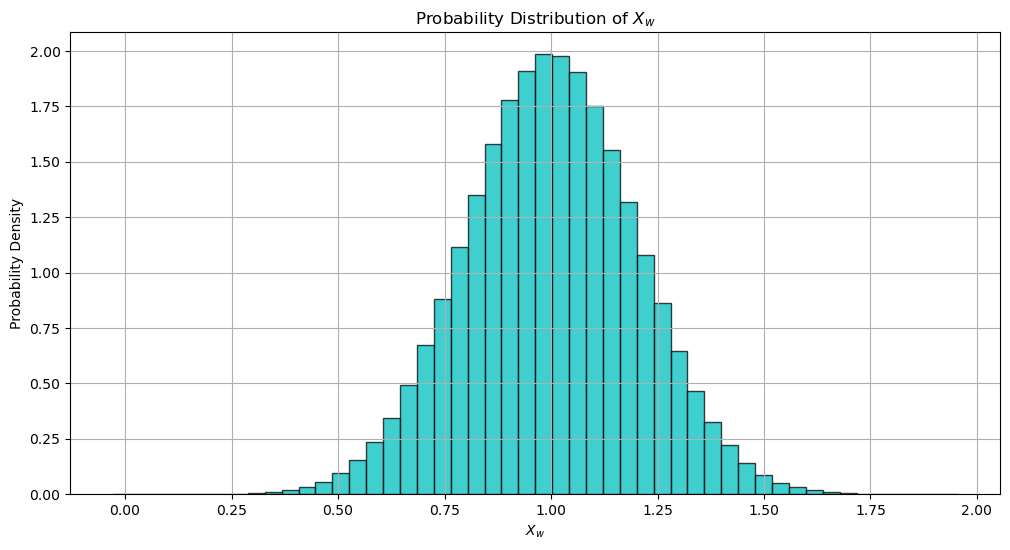

In [13]:
# Convert the Timestamp to datetime format and set it as index
Hovsore_filtered_data['Timestamp'] = pd.to_datetime(Hovsore_filtered_data['Timestamp'], format='%Y%m%d%H%M')
Hovsore_filtered_data.set_index('Timestamp', inplace=True)

# Define a function to perform bootstrap sampling using continuous segments
def bootstrap_continuous_segments(data, sample_size, n_bootstrap):
    """
    Perform bootstrap sampling with continuous segments.

    Parameters:
    data (pd.Series): Wind speed data to be sampled.
    sample_size (int): The number of points in each bootstrap sample.
    n_bootstrap (int): The number of bootstrap samples.

    Returns:
    list of np.ndarray: List of bootstrap samples.
    """
    total_length = len(data)
    bootstrap_samples = []
    
    for _ in range(n_bootstrap):
        # Randomly select a starting point ensuring that the sample will not exceed the data length
        start_index = np.random.randint(0, total_length - sample_size)
        # Select a continuous segment of data
        sample = data.iloc[start_index:start_index + sample_size].values
        bootstrap_samples.append(sample)
    
    return bootstrap_samples

# Parameters for bootstrap sampling
sample_size = 10000  # Number of points in each bootstrap sample
n_bootstrap = 100  # Number of bootstrap samples

# Get bootstrap samples using the wind speed column
wind_speed_samples = bootstrap_continuous_segments(Hovsore_filtered_data['Wsp'], sample_size, n_bootstrap)
'''
# Visualize the first 5 bootstrap samples to verify the continuity
plt.figure(figsize=(14, 6))
for i, sample in enumerate(wind_speed_samples[:5]):
    plt.plot(sample, label=f'Sample {i+1}')
plt.title('Continuous Segments of Bootstrap Samples')
plt.xlabel('Sample Index')
plt.ylabel('Wind Speed (m/s)')
plt.legend()
plt.grid()
plt.show()
'''


# Define parameters for X_w
mean_Xw = 1  # Mean of X_w
cov_Xw = 0.2  # Coefficient of Variation of X_w
std_Xw = mean_Xw * cov_Xw  # Standard deviation of X_w

# Introduce 1% measurement and fitting uncertainty
measurement_uncertainty_factor = 0.01
fitting_uncertainty_factor = 0.01

# Apply uncertainties to each bootstrap sample and calculate corresponding X_w values
x_w_values = []
for sample in wind_speed_samples:
    # Apply measurement uncertainty
    sample_with_uncertainty = sample * (1 + np.random.normal(0, measurement_uncertainty_factor, len(sample)))
    
    # Apply fitting uncertainty
    sample_with_uncertainty = sample_with_uncertainty * (1 + np.random.normal(0, fitting_uncertainty_factor, len(sample)))
    
    # Calculate X_w using the normal distribution with mean 1 and CoV
    x_w_sample = np.random.normal(mean_Xw, std_Xw, len(sample_with_uncertainty))
    
    # Store the X_w values
    x_w_values.extend(x_w_sample)

# Visualize the probability distribution of X_w
plt.figure(figsize=(12, 6))
plt.hist(x_w_values, bins=50, density=True, alpha=0.75, color='c', edgecolor='black')
plt.title('Probability Distribution of $X_w$')
plt.xlabel('$X_w$')
plt.ylabel('Probability Density')
plt.grid(True)
plt.show()
